# 01_fetch_prometheus

Первичный запрос данных из Prometheus и первичный EDA.

In [1]:
from src.data_loader import fetch_frame
df = fetch_frame()
# df = fetch_frame(
#     use_cache=True,
#     cache_filename="my_custom_data.parquet"
# )
df.head()

df.info()

df.describe()

df.isnull().sum()


Fetching common_delay_p90 from Prometheus for chunk: 2025-04-27 21:00:00 to 2025-04-28 01:10:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 01:10:00 to 2025-04-28 05:20:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 05:20:00 to 2025-04-28 09:30:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 09:30:00 to 2025-04-28 13:40:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 13:40:00 to 2025-04-28 17:50:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 17:50:00 to 2025-04-28 22:00:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-28 22:00:00 to 2025-04-29 02:10:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 02:10:00 to 2025-04-29 06:20:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 06:20:00 to 2025-04-29 10:30:00
Fetching common_delay_p90 from Prometheus for chunk: 2025-04-29 10:30:00 to 2025-04-29 14:40:00
Fetching common_delay_p90 from Prometheu

common_delay_p90    2
dtype: int64

<Axes: xlabel='ts'>

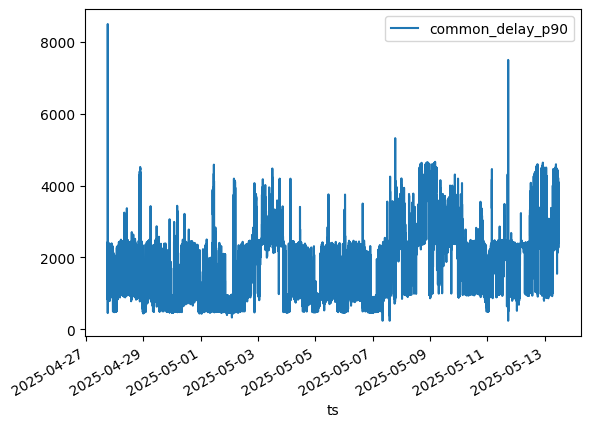

In [2]:
df.plot()

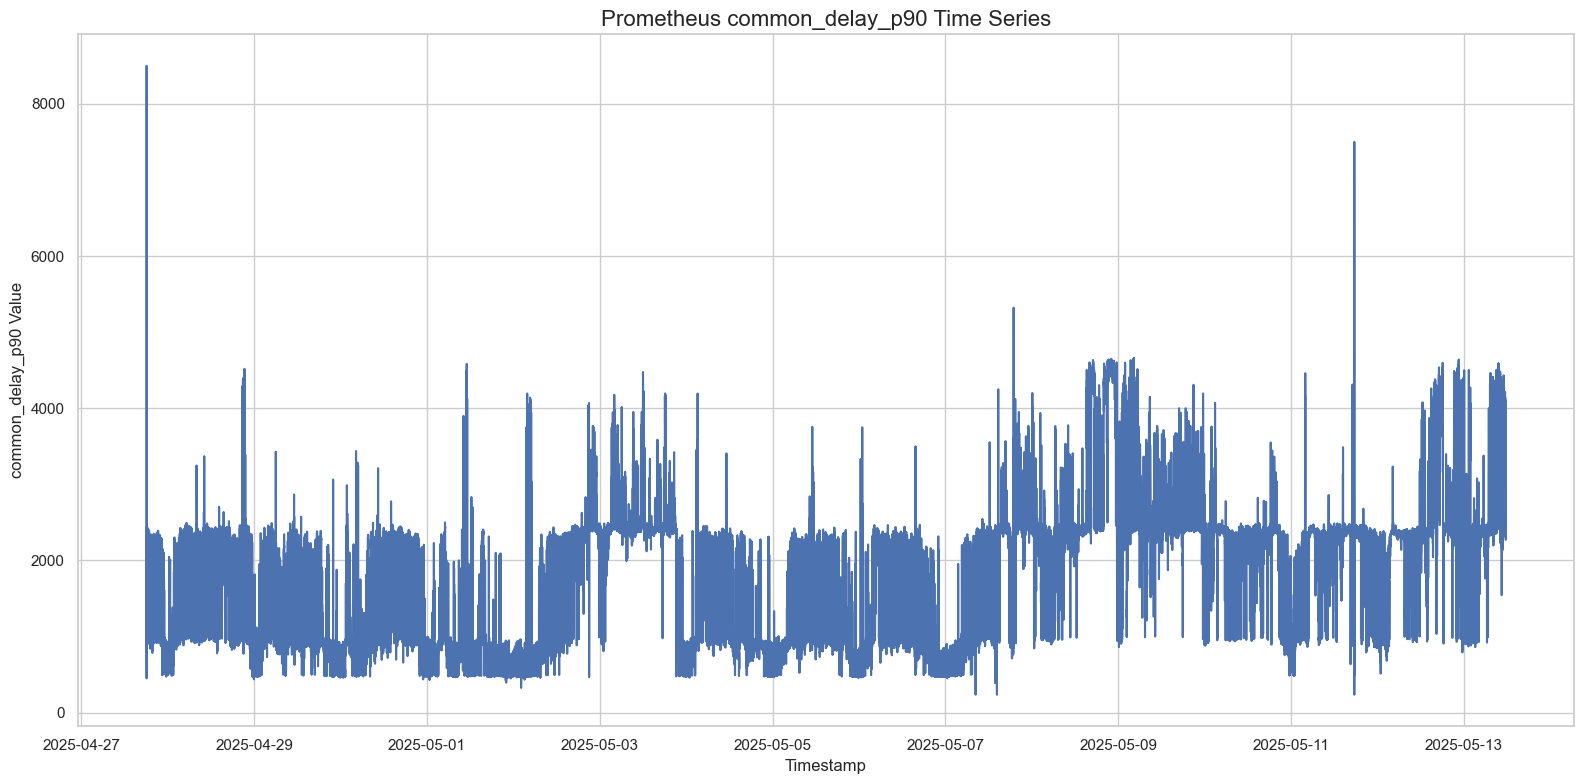

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plot style
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 8))

# Plot the common_delay_p90 series
sns.lineplot(data=df['common_delay_p90'])
plt.title('Prometheus common_delay_p90 Time Series', fontsize=16)
plt.xlabel('Timestamp', fontsize=12)
plt.ylabel('common_delay_p90 Value', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/hz/g0q481y17153sdyxw9_71p380000gn/T/ipykernel_84414/2529452834.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')


Hourly resampled data info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 378 entries, 2025-04-27 18:00:00 to 2025-05-13 11:00:00
Freq: h
Series name: common_delay_p90
Non-Null Count  Dtype  
--------------  -----  
378 non-null    float64
dtypes: float64(1)
memory usage: 5.9 KB

Missing values after resampling:
0


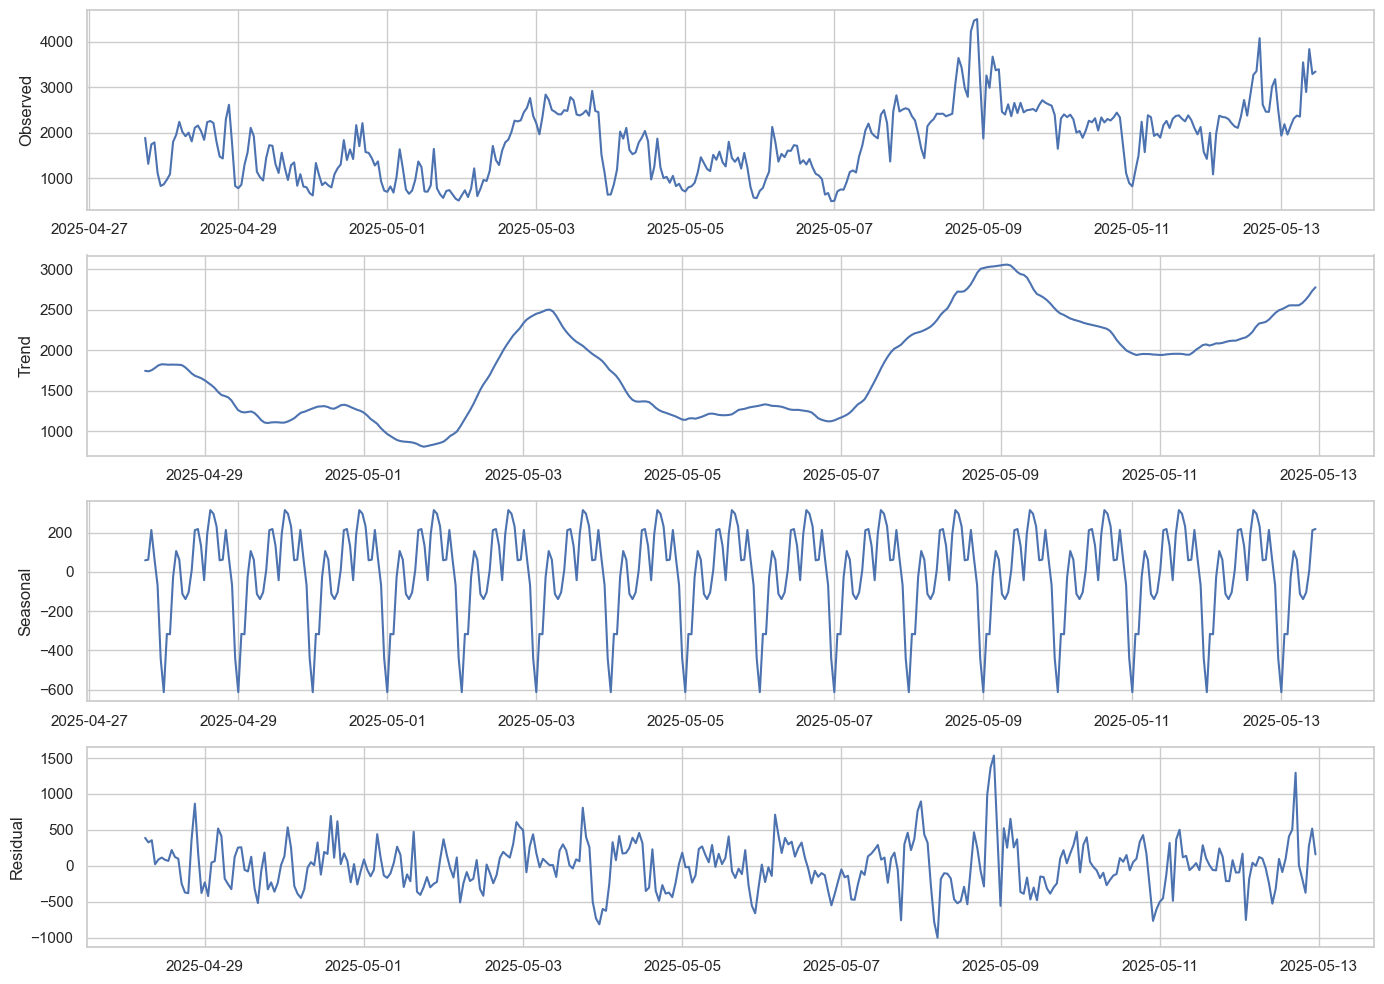

In [4]:

# Resample the data to an hourly frequency for easier analysis
df_hourly = df['common_delay_p90'].resample('1H').mean().interpolate(method='time')

print("Hourly resampled data info:")
df_hourly.info()
print("\nMissing values after resampling:")
print(df_hourly.isnull().sum())

# Perform seasonal decomposition (assuming daily seasonality for hourly data)
# Period for daily seasonality with hourly data is 24
decomposition = seasonal_decompose(df_hourly, model='additive', period=24)

# Plot decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

Hourly resampled data info:
<class 'pandas.core.series.Series'>
DatetimeIndex: 90733 entries, 2025-04-27 18:00:30 to 2025-05-13 11:41:00
Series name: common_delay_p90
Non-Null Count  Dtype  
--------------  -----  
90733 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB

Missing values after resampling:
0


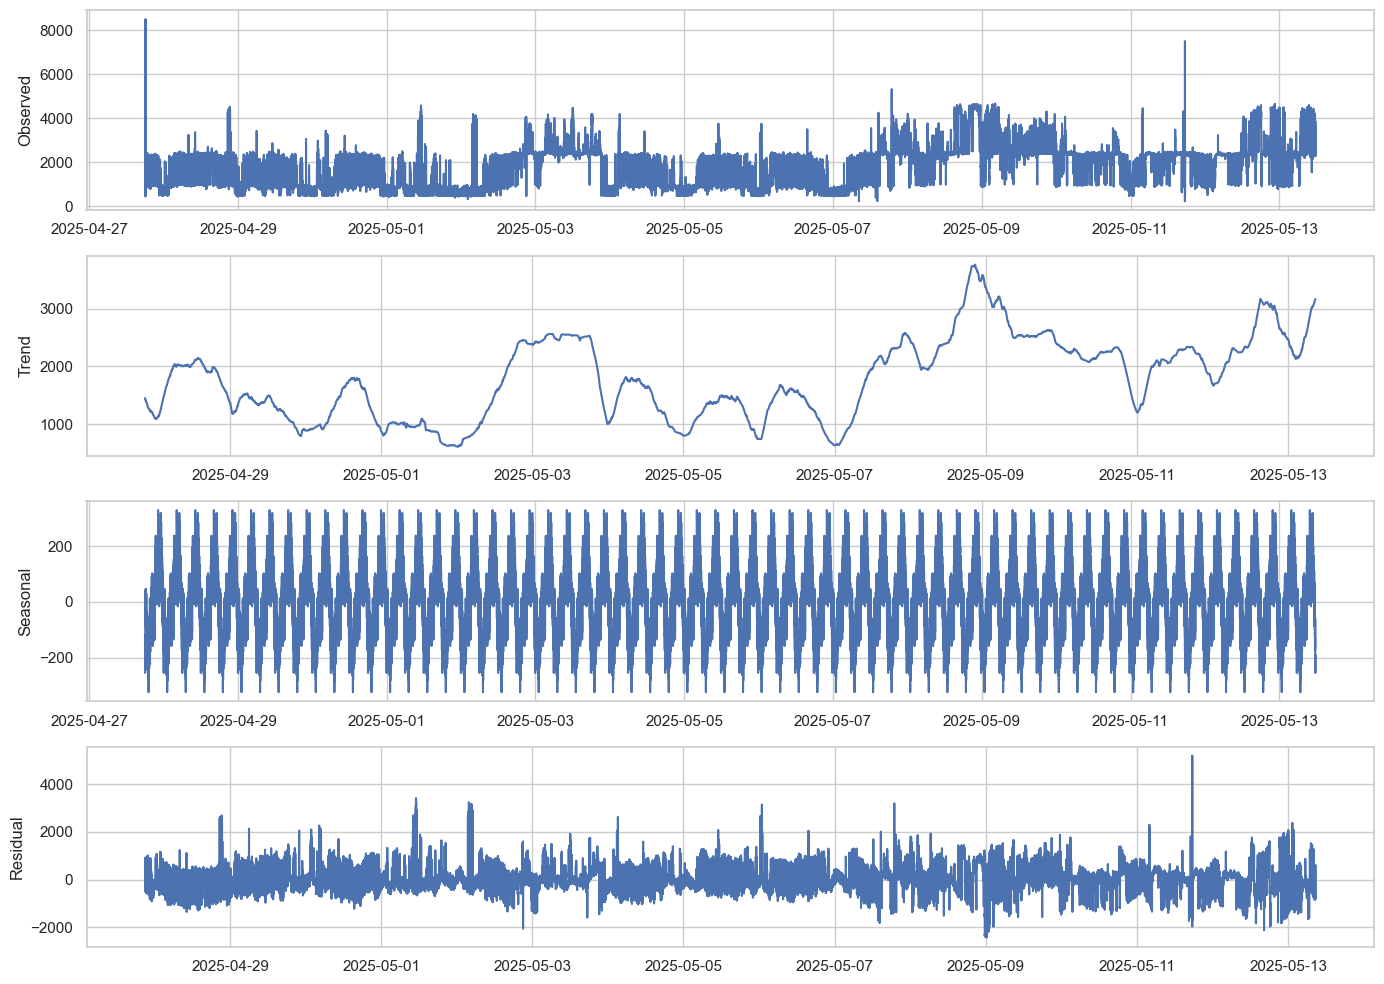

In [8]:

# Resample the data to an hourly frequency for easier analysis
df_minutely = df['common_delay_p90'].resample('5m').mean().interpolate(method='time')
# df_minutely = df['common_delay_p90'].interpolate(method='time')

print("Hourly resampled data info:")
df_minutely.info()
print("\nMissing values after resampling:")
print(df_minutely.isnull().sum())

decomposition = seasonal_decompose(df_minutely, model='additive', period=24*12)

# Plot decomposition
plt.figure(figsize=(14, 10))
plt.subplot(411)
plt.plot(decomposition.observed)
plt.ylabel('Observed')
plt.subplot(412)
plt.plot(decomposition.trend)
plt.ylabel('Trend')
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonal')
plt.subplot(414)
plt.plot(decomposition.resid)
plt.ylabel('Residual')
plt.tight_layout()
plt.show()

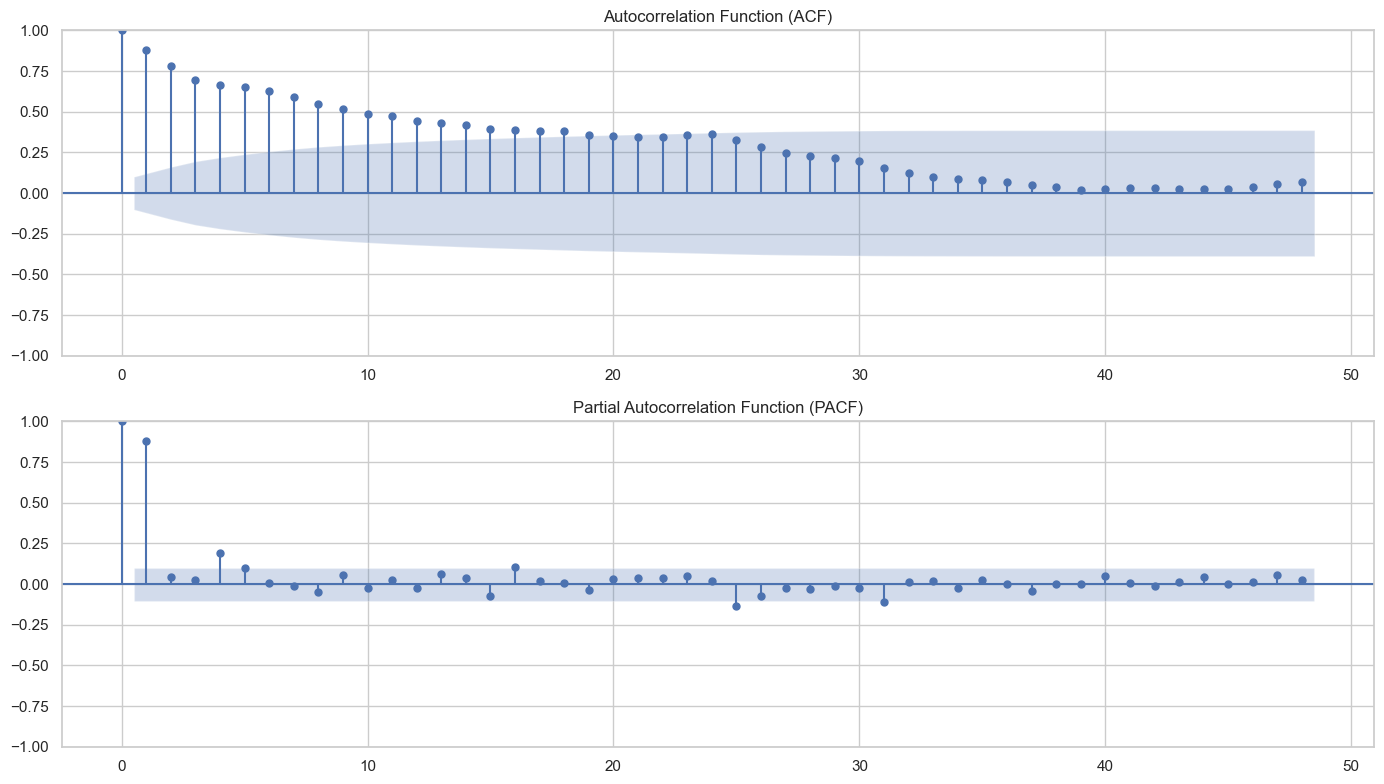

In [5]:
# Plot ACF and PACF to identify potential AR/MA components and seasonality
plt.figure(figsize=(14, 8))
plt.subplot(211)
plot_acf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Autocorrelation Function (ACF)')
plt.subplot(212)
plot_pacf(df_hourly.dropna(), lags=48, ax=plt.gca(), title='Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()